In [16]:
import pandas as pd
import math
import numpy as np 
import string
import time

from IPython import get_ipython

get_ipython().magic('run -i "functions_helper.py"')

## Data Preprocessing

In [2]:
# load corpus as preprocessed set of documents
corpus = pd.read_csv('nfcorpus/dev.docs', sep='\t', names=['ID', 'TEXT'])

# corpus preprocessing
corpus = preprocess_corpus(corpus)
# preview first rows
corpus.head()

,ID,TEXT
0,MED-118,alkylphenol human milk relat dietari habit cen...
1,MED-329,phosphat vascular toxin pubm ncbi abstract ele...
2,MED-330,dietari phosphoru acut impair endotheli functi...
3,MED-332,public health impact dietari phosphoru excess ...
4,MED-334,differ total vitro digest phosphoru content pl...


In [3]:
# load some queries for testing
queries_text = pd.read_csv('nfcorpus/dev.all.queries', sep='\t', names=['ID', 'TEXT'])

queries_text = preprocess_queries(corpus, queries_text, output_string=True)
queries_text.head(10)

,ID,TEXT
0,PLAIN-1,deep fri food may caus cancer latest studi die...
1,PLAIN-1007,ddt persist organ pollut industri toxin pestic...
2,PLAIN-101,treat multipl sclerosi diet multipl sclerosi u...
3,PLAIN-1017,detoxif cancer raw food heart health heart dis...
4,PLAIN-1027,dietari guidelin heart diseas cardiovascular d...
5,PLAIN-1038,dog meat anim product cat heart health tobacco...
6,PLAIN-1049,dr heart health heart diseas egg cholesterol s...
7,PLAIN-1065,dr walter mortal heart diseas heart health die...
8,PLAIN-1077,thyroid health hijiki sushi iodin sea veget sa...
9,PLAIN-1087,easter island mortal muscl strength morbid moo...


# Load Query-Doc Relevance

In [11]:
#upload the query relevance
queries_relevance = pd.read_csv('nfcorpus/dev.2-1-0.qrel', sep='\t', names=['QUERY_ID', '0', 'DOC_ID', 'RELEVANCE_LEVEL'])
queries_relevance.head(10)

,QUERY_ID,0,DOC_ID,RELEVANCE_LEVEL
0,PLAIN-1,0,MED-2421,2
1,PLAIN-1,0,MED-2422,2
2,PLAIN-1,0,MED-2416,2
3,PLAIN-1,0,MED-2423,2
4,PLAIN-1,0,MED-2417,2
5,PLAIN-1,0,MED-2418,2
6,PLAIN-1,0,MED-4451,2
7,PLAIN-1,0,MED-2420,2
8,PLAIN-1,0,MED-2414,1
9,PLAIN-1,0,MED-4070,1


##  Create TF-IDF matrix for documents

In [4]:
#create TF-IDF matrix of corpus
tf_dict = tf(corpus, column_name = 'TEXT')
idf_dict = idf(corpus, tf_dict)
tf_idf_dict = tf_idf(tf_dict, idf_dict)
tf_idf_matrix = tf_idf_to_matrix(tf_idf_dict)
tf_idf_matrix.head()

,alkylphenol,human,milk,relat,dietari,habit,central,taiwan,pubm,ncbi,...,six-year,inchianti,tuscani,studies-depress,eurosav,self-inflict,eurostat,suicide-record,scarciti,trim-and-fil
0,6.122806,2.886416,6.547579,2.90854,2.095849,5.898499,3.473596,5.503767,0.266507,0.27307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.266507,0.27307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.00000,2.597750,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.00000,2.597750,0.000000,0.000000,0.000000,0.266507,0.27307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.266507,0.27307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create TF-IDF matrix for queries

In [ ]:
%%time
#create tf-idf matrix of queries
tf_idf_queries = tf_idf_matrix[0:0]
tf_idf_queries.head()

for i in range(len(queries_text)):
    tf_idf_queries = tf_idf_queries.append(pd.Series(0, index=tf_idf_queries.columns), ignore_index=True)
    #count occurances
    for token in (queries_text['TEXT'][i]).split():
        for col in tf_idf_queries.columns:
            if token == col:
                tf_idf_queries[col][i] = tf_idf_queries[col][i] + 1
                
#calculate log tf
tf_idf_queries = np.log(tf_idf_queries) + 1 

tf_idf_queries = tf_idf_queries.replace(-np.inf,0)

for i in range(len(queries_text)):
    for col in tf_idf_queries.columns:
        tf_idf_queries[col][i] = tf_idf_queries[col][i] * idf_dict[col]

tf_idf_queries.head()

# Create vectors

In [7]:
#create variables for document and query vectors
doc_vectors = tf_idf_matrix.values
q_vectors = tf_idf_queries.values
#test the basic retrieve
retrieve(0, q_vectors, doc_vectors, k=10)

,ID,TEXT
1142,MED-2423,dietari pattern breast cancer risk women pubm ...
1138,MED-2418,consumpt deep-fri food risk prostat cancera b ...
956,MED-2195,influenc deep fri veget oil acrylamid format s...
1794,MED-3498,dietari acrylamid exposur french popul result ...
1141,MED-2422,statist regress model estim acrylamid concentr...
303,MED-1363,toward healthier mediterranean diet pubm ncbi ...
658,MED-1814,dietari pattern risk pancreat cancer larg popu...
3004,MED-5088,mitig strategi reduc acrylamid format fri pota...
1135,MED-2414,review epidemiolog studi dietari acrylamid int...
2521,MED-4482,meat consumpt cook practic meat mutagen risk p...


In [12]:
%%time
vanilla_evaluation = full_evaluation(q_vectors, doc_vectors, k=5)

Average precision across all queries = 0.32925641025641056
Mean Average Precision = 0.19030116867259733
Average nDCG = 0.2939300969738308
Wall time: 8min 2s


In [13]:
vanilla_evaluation.head()

,ID,TEXT,Precision,Average Precision,nDCG
0,PLAIN-1,deep fri food may caus cancer latest studi die...,0.6,0.294643,0.375189
1,PLAIN-1007,ddt persist organ pollut industri toxin pestic...,0.3,0.072619,0.209049
2,PLAIN-101,treat multipl sclerosi diet multipl sclerosi u...,0.2,0.039286,0.131090
3,PLAIN-1017,detoxif cancer raw food heart health heart dis...,0.0,0.000000,0.000000
4,PLAIN-1027,dietari guidelin heart diseas cardiovascular d...,0.3,0.095000,0.243552


# Random projections

In [17]:
#create normalized random vectors

np.random.seed(0)
vocab_size = len(tf_idf_matrix.columns)
random_vectors = get_random_vectors(vocab_size, m = 15000)

print('dimension of the set of random vectors: ', random_vectors.shape)
print(random_vectors[1])
print(np.linalg.norm(random_vectors[1]))


dimension of the set of random vectors:  (15000, 19930)
[-0.01483543  0.00217144  0.00685049 ... -0.01615313 -0.0048027
 -0.00412668]
1.0


In [25]:
inn = norm(doc_vectors)[1].dot(random_vectors.transpose())
print(np.mean(inn))

2.068746243613521e-06


In [ ]:
import matplotlib.pyplot as plt
#### test compute_hash
m=[]
for i in range(3193):
    inn = norm(doc_vectors)[i].dot(random_vectors.transpose())
    m.append(np.mean(inn))

plt.plot(range(3193),m)
plt.show()

In [27]:
print(np.mean(m))

-1.0177735845265945e-05


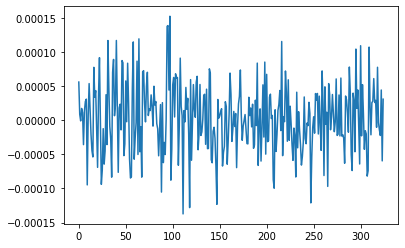

In [29]:

m_q=[]
for i in range(325):
    inn = norm(q_vectors)[i].dot(random_vectors.transpose())
    m_q.append(np.mean(inn))

plt.plot(range(325),m_q)
plt.show()

In [30]:
print(np.mean(m_q))

2.7229810417023175e-06


In [31]:
tf_idf_matrix.shape

(3193, 19930)

# Create new document vectors with reduced dimensionality

In [32]:
#compute new document vectors with reduced dimensionality
doc_projections = compute_hash(norm(doc_vectors), random_vectors, 0)
doc_projections[1]

array([1, 1, 1, ..., 0, 0, 1])

# Create new query vectors with reduced dimensionality

In [33]:
#compute new query vectors with reduced dimensionality
q_projections = compute_hash(norm(q_vectors),random_vectors, 0)

# Random projections evaluation

In [34]:
%%time
rand_proj_evaluation = full_evaluation(q_projections, doc_projections, k=10, random_projections = True)

Average precision across all queries = 0.2986471306471307
Mean Average Precision = 0.16729202327654727
Average nDCG = 0.26535569552832705
Wall time: 19 s


In [35]:
rand_proj_evaluation.head()

,ID,TEXT,Precision,Average Precision,nDCG
0,PLAIN-1,deep fri food may caus cancer latest studi die...,0.700000,0.507778,0.498844
1,PLAIN-1007,ddt persist organ pollut industri toxin pestic...,0.333333,0.090833,0.232973
2,PLAIN-101,treat multipl sclerosi diet multipl sclerosi u...,0.200000,0.039286,0.131090
3,PLAIN-1017,detoxif cancer raw food heart health heart dis...,0.000000,0.000000,0.000000
4,PLAIN-1027,dietari guidelin heart diseas cardiovascular d...,0.300000,0.095000,0.243552


Average precision across all queries = 0.13457753357753366
Mean Average Precision = 0.055278454173692246
Average nDCG = 0.11519423510788916
Average precision across all queries = 0.2499487179487181
Mean Average Precision = 0.12887216504835552
Average nDCG = 0.22084762583987164
Average precision across all queries = 0.28494261294261314
Mean Average Precision = 0.15415233249995164
Average nDCG = 0.2518501463266408
Average precision across all queries = 0.3097362637362639
Mean Average Precision = 0.17711277690563415
Average nDCG = 0.27555150854947086


<function matplotlib.pyplot.show(*args, **kw)>

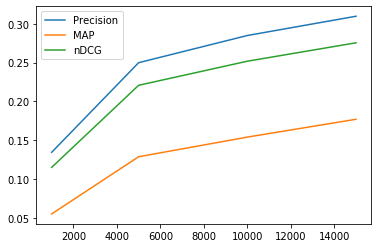

In [36]:
precision=[]
MAP=[]
nDCG=[]
for i in [1000, 5000, 10000, 15000]:
    start_time_rand_vect = time.time()
    random_vectors_test = get_random_vectors(vocab_size, m = i)

    doc_projections_test = compute_hash(norm(doc_vectors), random_vectors_test, 0)

    q_projections_test = compute_hash(norm(q_vectors),random_vectors_test, 0)
    
    rand_proj_evaluation_test = full_evaluation(q_projections_test, doc_projections_test, k=10, random_projections = True)
    
    precision.append(rand_proj_evaluation_test['Precision'].mean())
    MAP.append(rand_proj_evaluation_test['Average Precision'].mean())
    nDCG.append(rand_proj_evaluation_test['nDCG'].mean())
    
plt.plot([1000, 5000, 10000, 15000], precision, label = "Precision")
plt.plot([1000, 5000, 10000, 15000], MAP, label = "MAP")
plt.plot([1000, 5000, 10000, 15000], nDCG, label = "nDCG")
plt.legend()
plt.show

In [ ]:
time_get_rand_vec = []
time_hash_norm_doc = []
time_hash_norm_q=[]
time_evaluation=[]
for i in [1000, 5000, 10000, 15000]:
    start_time_rand_vect = time.time()
    random_vectors_test = get_random_vectors(vocab_size, m = i)
    time_get_rand_vec.append(time.time()-start_time_rand_vect)
    
    start_hash_norm_doc = time.time()
    doc_projections_test = compute_hash(norm(doc_vectors), random_vectors_test, 0)
    time_hash_norm_doc.append(time.time() - start_hash_norm_doc)
    
    start_hash_norm_q = time.time()
    q_projections_test = compute_hash(norm(q_vectors),random_vectors_test, 0)
    time_hash_norm_q.append(time.time() - start_hash_norm_q)
    
    start_evaluation = time.time()
    rand_proj_evaluation_test = full_evaluation(q_projections_test, doc_projections_test, k=10, random_projections = True)
    time_evaluation.append(time.time() - start_evaluation)
    
plt.plot([1000, 5000, 10000, 15000], time_get_random_vect, label = "Generate random vectors")
plt.plot([1000, 5000, 10000, 15000], time_get_random_vect, label = "Project doc vectors")
plt.plot([1000, 5000, 10000, 15000], time_get_random_vect, label = "Project query vectors")
plt.plot([1000, 5000, 10000, 15000], time_get_random_vect, label = "Evaluation")
plt.legend()
plt.show()

